2024-08-02 16:41:26.898632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:41:26.933517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:41:26.943903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 16:41:26.967030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 16:41:29.055385: W tensorflow/comp

Best Parameters: {'batch_size': 64, 'epochs': 500, 'optimizer': 'nadam', 'learning_rate': 0.01}
Best Score: 1410871066624.0
Elapsed Time: 614.35 seconds
Epoch 1/500
74/74 - 4s - 56ms/step - loss: 287593090514944.0000 - mse: 287593090514944.0000 - val_loss: 18087862599680.0000 - val_mse: 18087862599680.0000 - learning_rate: 0.0100
Epoch 2/500
74/74 - 0s - 6ms/step - loss: 66624333807616.0000 - mse: 66624333807616.0000 - val_loss: 14509754286080.0000 - val_mse: 14509754286080.0000 - learning_rate: 0.0100
Epoch 3/500
74/74 - 1s - 8ms/step - loss: 56191271043072.0000 - mse: 56191271043072.0000 - val_loss: 7724735135744.0000 - val_mse: 7724735135744.0000 - learning_rate: 0.0100
Epoch 4/500
74/74 - 0s - 5ms/step - loss: 56276830650368.0000 - mse: 56276830650368.0000 - val_loss: 12317415702528.0000 - val_mse: 12317415702528.0000 - learning_rate: 0.0100
Epoch 5/500
74/74 - 0s - 6ms/step - loss: 53562784612352.0000 - mse: 53562784612352.0000 - val_loss: 10459409285120.0000 - val_mse: 1045940928

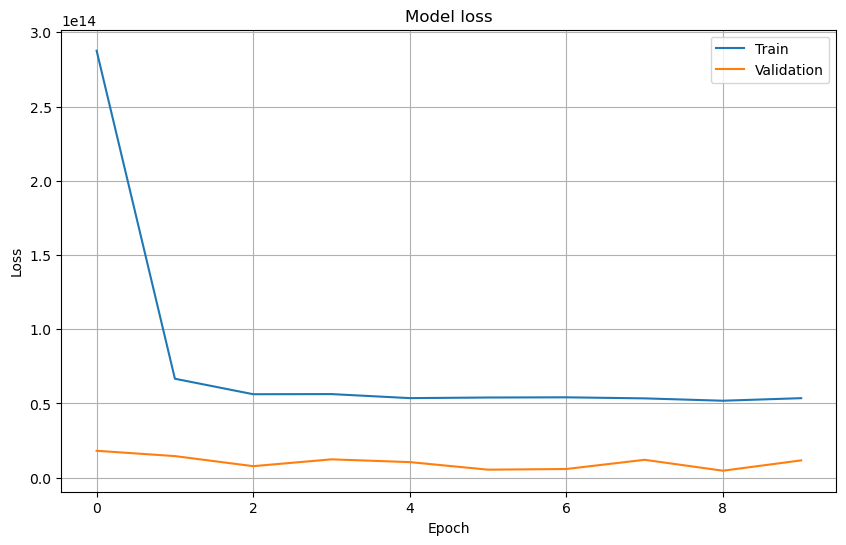

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Updated_New_cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Remove all columns related to time in seconds, minutes, and hours
columns_to_remove = ['time_diff_sec', 'time_diff_min', 'time_diff_hours']
data_cleaned = data.drop(columns=columns_to_remove)

# Define the target variable
target = 'time_diff_days'
X = data_cleaned.drop(columns=[target])
y = data_cleaned[target]

# Drop object type columns from features
X = X.select_dtypes(exclude=['object'])

# Split the dataset into training and testing sets with an 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using StandardScaler to scale the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the PCA model with 10 components
pca = PCA(n_components=10)

# Fit the model on the scaled data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert the transformed data to a DataFrame
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])

# Define a function to create the neural network model
def create_model(optimizer, learning_rate):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_pca.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    
    return model

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [32, 64],
    'epochs': [500, 1000],
    'optimizer': ['adam', 'rmsprop', 'nadam'],
    'learning_rate': [0.001, 0.01]
}

best_score = float('inf')
best_params = {}

# Start timing the hyperparameter tuning process
start_time = time.time()

# Manually perform grid search
for batch_size in tqdm(param_grid['batch_size'], desc='Batch size'):
    for epochs in tqdm(param_grid['epochs'], desc='Epochs'):
        for optimizer in tqdm(param_grid['optimizer'], desc='Optimizers'):
            for learning_rate in tqdm(param_grid['learning_rate'], desc='Learning rates'):
                model = create_model(optimizer, learning_rate)
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
                history = model.fit(X_train_pca, y_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size, 
                                    validation_data=(X_test_pca, y_test),
                                    verbose=0,
                                    callbacks=[early_stopping, reduce_lr])
                test_loss, test_mse = model.evaluate(X_test_pca, y_test, verbose=0)
                if test_mse < best_score:
                    best_score = test_mse
                    best_params = {
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'optimizer': optimizer,
                        'learning_rate': learning_rate
                    }

# End timing the hyperparameter tuning process
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')
print(f'Elapsed Time: {elapsed_time:.2f} seconds')

# Train final model with the best hyperparameters
best_model = create_model(best_params['optimizer'], best_params['learning_rate'])
history = best_model.fit(X_train_pca, y_train, 
                         epochs=best_params['epochs'], 
                         batch_size=best_params['batch_size'], 
                         validation_data=(X_test_pca, y_test),
                         verbose=2,
                         callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test data
test_loss, test_mse = best_model.evaluate(X_test_pca, y_test, verbose=2)
print(f'Test MSE: {test_mse}')

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


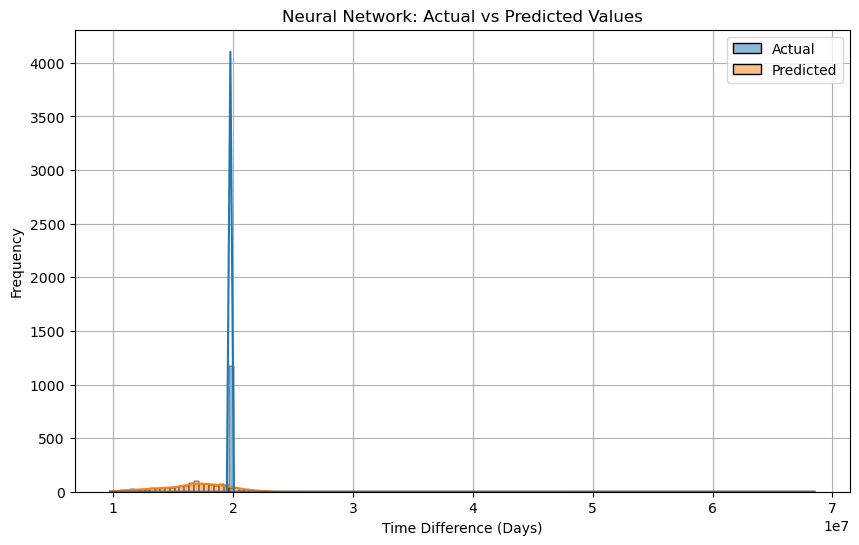

In [2]:
results_df_nn = pd.DataFrame({'Actual': y_test, 'Predicted': best_model.predict(X_test_pca).flatten()})

# Plot actual vs predicted values for Neural Network
plt.figure(figsize=(10, 6))
sns.histplot(results_df_nn, kde=True)
plt.title('Neural Network: Actual vs Predicted Values')
plt.xlabel('Time Difference (Days)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

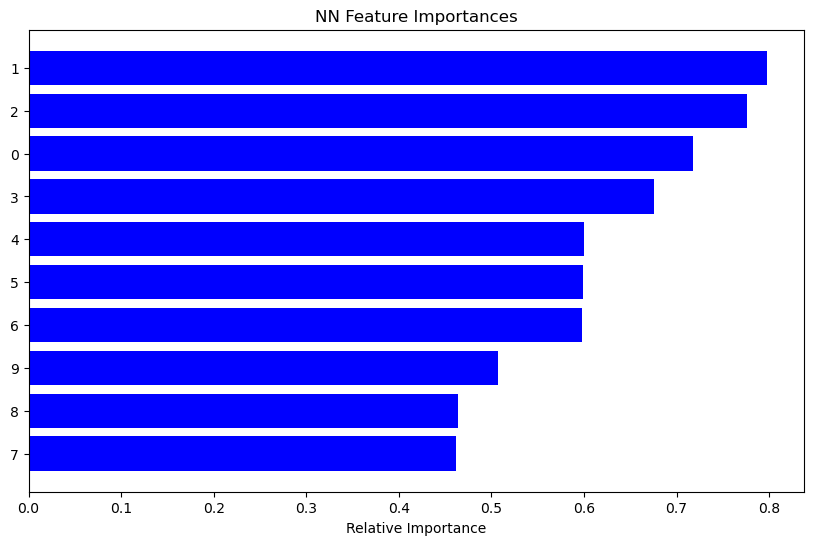

In [3]:
def get_feature_importances(model):
    # Get the absolute weights of the first layer (input layer)
    weights = model.layers[0].get_weights()[0]  # 0 for weights, 1 for biases
    feature_importances = np.mean(np.abs(weights), axis=1)  # Mean across output nodes for simplicity
    return feature_importances

# Plot feature importances
def plot_feature_importances(importances, title='Feature Importances'):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importances)
    plt.title(title)
    plt.barh(range(len(importances)), importances[indices], color='b', align='center')
    plt.yticks(range(len(importances)), indices)
    plt.xlabel('Relative Importance')
    plt.show()

# Extract and plot feature importances
importances = get_feature_importances(best_model)
plot_feature_importances(importances, 'NN Feature Importances')

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# Add NN results to the comparison
results = {'MSE': test_mse, 'RMSE': np.sqrt(test_mse), 'MAPE': np.mean(np.abs((y_test - best_model.predict(X_test_pca).flatten()) / y_test)) * 100, 'R2': r2_score(y_test, best_model.predict(X_test_pca).flatten()), 'Best Params': best_params}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T



# Display the DataFrame
results_df

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,batch_size,epochs,optimizer,learning_rate
MSE,18087862599680.0,18087862599680.0,18087862599680.0,18087862599680.0
RMSE,4252982.788547,4252982.788547,4252982.788547,4252982.788547
MAPE,16.534111,16.534111,16.534111,16.534111
R2,-17602.866691,-17602.866691,-17602.866691,-17602.866691
Best Params,64,500,nadam,0.01


In [ ]:
# pip install keras-tuner

### Using Random search

In [ ]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

# Define a function to create the model for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), input_dim=X_train_pca.shape[1], activation='relu'))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam']),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Choose the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='helloworld'
)


# Search for the best hyperparameters
tuner.search(X_train_pca, y_train, epochs=500, validation_data=(X_test_pca, y_test), verbose=0)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pca, y_train, epochs=500, validation_data=(X_test_pca, y_test), verbose=2)

# Evaluate the model on the test data
test_loss, test_mse = model.evaluate(X_test_pca, y_test, verbose=2)
print(f'Test MSE: {test_mse}')

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

/tmp/ipykernel_20505/535982210.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/laye